In [1]:
# %pip install plotly
# %pip install nbformat
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

os.getcwd()

'/Users/aneeshussain/Code/diss/analysis'

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Change directory to the parent directory (diss)
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
os.chdir(parent_dir)

# Append the parent directory to the system path (optional, if you want to add it to the import path)
sys.path.append(parent_dir)

# Print the new current working directory to confirm the change
print(f"Changed directory to: {os.getcwd()}")

Changed directory to: /Users/aneeshussain/Code/diss


In [3]:
import pandas as pd

# Filepaths for each exchange
filepaths = {
    'binance': './data/processed/binance.csv',
    'okx': './data/processed/okx.csv',
    'bybit': './data/processed/bybit.csv'
}

# List of specified pairs
specified_pairs = ['BTCUSDCM', 'BTCUSDT', 'ETHUSDCM', 'ETHUSDT']

# Initialize a dictionary to store counts for each exchange
exchange_funding_stats = {}

# Loop through each exchange
for exchange, filepath in filepaths.items():
    # Load the data for the current exchange
    df = pd.read_csv(filepath)

    # Convert 'funding rate' to float
    df['funding rate'] = pd.to_numeric(df['funding rate'], errors='coerce')

    # Filter the DataFrame to only include the specified pairs
    filtered_df = df[df['pair'].isin(specified_pairs)]

    # Initialize dictionaries to store counts for this exchange
    positive_funding_counts = {}
    total_funding_counts = {}

    # Iterate through each specified pair
    for pair in specified_pairs:
        # Filter rows for the current pair
        pair_df = filtered_df[filtered_df['pair'] == pair]

        # Count positive funding rates
        positive_count = (pair_df['funding rate'] > 0).sum()
        total_count = len(pair_df)

        # Store the counts in the dictionaries
        positive_funding_counts[pair] = positive_count
        total_funding_counts[pair] = total_count

    # Create a DataFrame for this exchange to display the counts
    funding_stats = pd.DataFrame({
        'positive_count': positive_funding_counts,
        'total_count': total_funding_counts
    })

    # Calculate the percentage of positive funding rates
    funding_stats['positive_percentage'] = (funding_stats['positive_count'] / funding_stats['total_count']) * 100

    # Store the result for this exchange
    exchange_funding_stats[exchange] = funding_stats

# Display the results for each exchange
for exchange, stats in exchange_funding_stats.items():
    print(f"{exchange} Funding stats")
    print(stats)
    print("\n")

binance Funding stats
          positive_count  total_count  positive_percentage
BTCUSDCM            1435         1642            87.393423
BTCUSDT             1517         1642            92.387333
ETHUSDCM            1467         1642            89.342266
ETHUSDT             1539         1642            93.727162


okx Funding stats
          positive_count  total_count  positive_percentage
BTCUSDCM            1132         1642            68.940317
BTCUSDT             1203         1642            73.264312
ETHUSDCM            1163         1642            70.828258
ETHUSDT             1226         1642            74.665043


bybit Funding stats
          positive_count  total_count  positive_percentage
BTCUSDCM            1472         1642            89.646772
BTCUSDT             1494         1642            90.986602
ETHUSDCM            1481         1642            90.194884
ETHUSDT             1474         1642            89.768575




In [72]:
funding_filepath = './results/test/funding_log.csv' 
funding_df = pd.read_csv(funding_filepath)

# Convert 'time' to datetime format
funding_df['time'] = pd.to_datetime(funding_df['time'])

# Extract the month to aggregate funding payments
funding_df['month'] = funding_df['time'].dt.to_period('M')

# Calculate cumulative profit over time (using the original 'funding payment' column)
funding_df['cumulative_profit'] = funding_df['funding payment'].cumsum()

# Aggregate monthly funding payments for cumulative profit
monthly_cumulative_profit = funding_df.groupby('month')['cumulative_profit'].last().reset_index()

# Separate positive and negative funding payments before aggregation
funding_df['positive'] = funding_df['funding payment'].apply(lambda x: x if x >= 0 else 0)
funding_df['negative'] = funding_df['funding payment'].apply(lambda x: x if x < 0 else 0)

# Sum monthly positive and negative funding payments
monthly_funding = funding_df.groupby('month').agg({
    'positive': 'sum',
    'negative': 'sum'
}).reset_index()

# Convert 'month' back to a datetime for plotting (use the start of each month)
monthly_funding['month'] = monthly_funding['month'].dt.to_timestamp()


# Plotting using Plotly
fig = go.Figure()

# Add bars for positive funding payments
fig.add_trace(go.Bar(
    x=monthly_funding['month'],
    y=monthly_funding['positive'],
    name='Positive Funding Payments',
    marker_color='green',
))

# Add bars for negative funding payments
fig.add_trace(go.Bar(
    x=monthly_funding['month'],
    y=monthly_funding['negative'],
    name='Negative Funding Payments',
    marker_color='red',
))



# Update layout for the plot
fig.update_layout(
    title='Monthly Funding Payments with Cumulative Profit',
    xaxis_title='Month',
    yaxis_title='Funding Payment (USD)',
    template='plotly_white',
    barmode='relative',  # Allow bars to overlap properly
    hovermode='x unified',
)

# Format x-axis to display months clearly
fig.update_xaxes(
    tickformat='%b %Y',  # Format to show month (e.g., Jan 2023)
    tickangle=45,
    showgrid=True,
)

# Show the plot
fig.show()

In [80]:
trades_filepath = './results/simple_threshold_open/trades_log.csv'
trades_df = pd.read_csv(trades_filepath)

# Convert 'open_time' and 'close_time' to datetime
trades_df['open_time'] = pd.to_datetime(trades_df['open_time'])
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])

# Filter for long positions
long_trades_df = trades_df[trades_df['position_type'] == 'long']

exchange_trade_count = long_trades_df['exchange'].value_counts()

# Display the count of trades on each exchange
print(exchange_trade_count)

exchange
okx        1128
bybit       353
binance     344
Name: count, dtype: int64


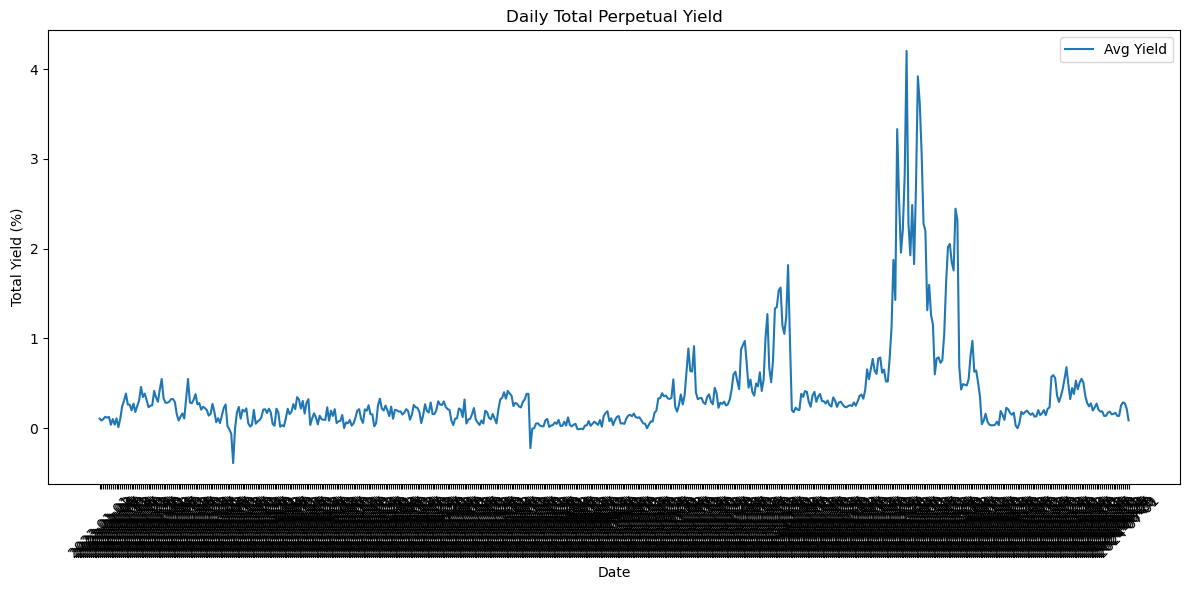

In [31]:
import matplotlib.pyplot as plt

yield_filepath = './results/test/yield.csv'
yield_df = pd.read_csv(yield_filepath)

# Calculate the total yield by summing the individual yields for each date
yield_df['total_yield'] = (
    yield_df['binance_btc_yield'] + 
    yield_df['binance_eth_yield'] + 
    yield_df['bybit_btc_yield'] + 
    yield_df['bybit_eth_yield'] + 
    yield_df['okx_btc_yield'] + 
    yield_df['okx_eth_yield']
)

# Plot the total perpetual yield
plt.figure(figsize=(12, 6))

plt.plot(yield_df['date'], yield_df['total_yield'] * 100, label='Avg Yield')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Yield (%)')
plt.title('Daily Total Perpetual Yield')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

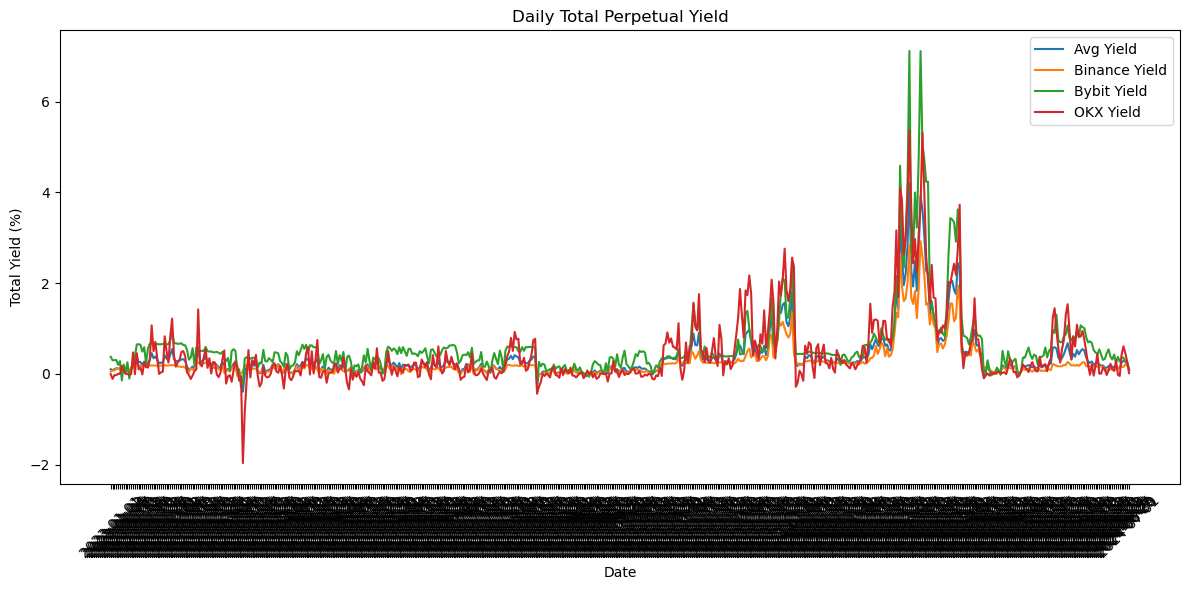

In [35]:
import matplotlib.pyplot as plt

yield_filepath = './results/test/yield.csv'
yield_df = pd.read_csv(yield_filepath)


plt.figure(figsize=(12, 6))

plt.plot(yield_df['date'], yield_df['binance_total_yield'] / 0.6 , label='Binance Yield')
plt.plot(yield_df['date'], yield_df['bybit_total_yield'] / 0.2, label='Bybit Yield')
plt.plot(yield_df['date'], yield_df['okx_total_yield'] / 0.2, label='OKX Yield')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Yield (%)')
plt.title('Daily Total Perpetual Yield')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

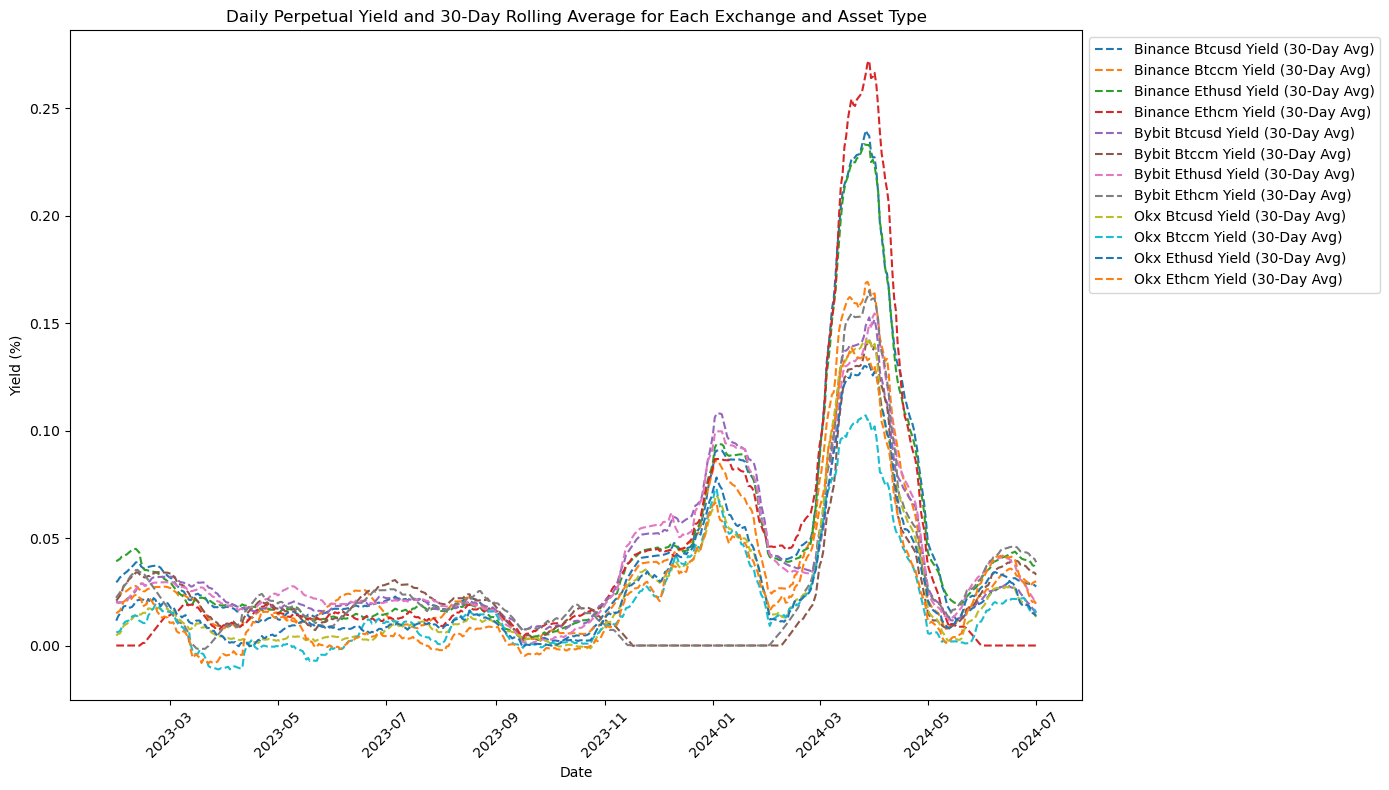

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

yield_filepath = './results/test/yield.csv'
yield_df = pd.read_csv(yield_filepath)

# Convert 'date' to datetime
yield_df['date'] = pd.to_datetime(yield_df['date'])

# Calculate a 30-day rolling average for each yield column
columns_to_average = [
    'binance_btcusd_yield', 'binance_btccm_yield', 'binance_ethusd_yield', 'binance_ethcm_yield',
    'bybit_btcusd_yield', 'bybit_btccm_yield', 'bybit_ethusd_yield', 'bybit_ethcm_yield',
    'okx_btcusd_yield', 'okx_btccm_yield', 'okx_ethusd_yield', 'okx_ethcm_yield'
]

for column in columns_to_average:
    yield_df[f'{column}_rolling'] = yield_df[column].rolling(window=30).mean()

plt.figure(figsize=(14, 8))

# Plot the yields for each exchange and asset type
for column in columns_to_average:
    # plt.plot(yield_df['date'], yield_df[column], label=f'{column.replace("_", " ").title()}')
    plt.plot(yield_df['date'], yield_df[f'{column}_rolling'], linestyle='--', label=f'{column.replace("_", " ").title()} (30-Day Avg)')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.title('Daily Perpetual Yield and 30-Day Rolling Average for Each Exchange and Asset Type')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [51]:
import pandas as pd
import plotly.graph_objects as go

trades_filepath = './results/test/trades_log.csv'
trades_df = pd.read_csv(trades_filepath)

trades_df['open_time'] = pd.to_datetime(trades_df['open_time'])
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])

trades_df['open_date'] = trades_df['open_time'].dt.date
trades_df['close_date'] = trades_df['close_time'].dt.date

trades_opened_per_day = trades_df['open_date'].value_counts().sort_index()

trades_closed_per_day = trades_df['close_date'].value_counts().sort_index()

trades_counts = pd.DataFrame({
    'date': pd.to_datetime(trades_opened_per_day.index),
    'trades_opened': trades_opened_per_day.values,
    'trades_closed': -trades_closed_per_day.reindex(trades_opened_per_day.index, fill_value=0).values
})

fig = go.Figure()

fig.add_trace(go.Bar(
    x=trades_counts['date'],
    y=trades_counts['trades_opened'],
    name='Position Opened',
    marker_color='green',
    opacity=1.0
))

# Add bars for trades closed
fig.add_trace(go.Bar(
    x=trades_counts['date'],
    y=trades_counts['trades_closed'],
    name='Position Closed',
    marker_color='red',
    opacity=1.0
))

fig.add_shape(
    type="line",
    x0=trades_counts['date'].min(), x1=trades_counts['date'].max(),
    y0=0, y1=0,
    line=dict(color="black", width=1)
)


fig.update_layout(
    title='Trading Volume',
    yaxis_title='Number of Trades',
    barmode='relative',
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    width=800,
    height=600
)

fig.update_xaxes(
    tickformat='%b %Y',
    tickangle=0,
    showgrid=True,
    zeroline=True,
    showticklabels=True,
    dtick='M3'
)

fig.show()

In [58]:
import pandas as pd
import plotly.graph_objects as go

trades_filepath = './results/test/trades_log.csv'
trades_df = pd.read_csv(trades_filepath)

trades_df['open_time'] = pd.to_datetime(trades_df['open_time'])
trades_df['close_time'] = pd.to_datetime(trades_df['close_time'])

trades_df['open_date'] = trades_df['open_time'].dt.date
trades_df['close_date'] = trades_df['close_time'].dt.date

trades_opened_per_day = trades_df['open_date'].value_counts().sort_index()

trades_closed_per_day = trades_df['close_date'].value_counts().sort_index()

trades_counts = pd.DataFrame({
    'date': pd.to_datetime(trades_opened_per_day.index),
    'trades_opened': trades_opened_per_day.values,
    'trades_closed': -trades_closed_per_day.reindex(trades_opened_per_day.index, fill_value=0).values
})

fig = go.Figure()

fig.add_trace(go.Bar(
    x=trades_counts['date'],
    y=trades_counts['trades_opened'],
    name='Position Opened',
    marker_color='green',
    opacity=1.0
))

fig.add_trace(go.Bar(
    x=trades_counts['date'],
    y=trades_counts['trades_closed'],
    name='Position Closed',
    marker_color='red',
    opacity=1.0
))

fig.add_shape(
    type="line",
    x0=trades_counts['date'].min(), x1=trades_counts['date'].max(),
    y0=0, y1=0,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title='Trading Volume',
    yaxis_title='Number of Trades',
    barmode='relative',
    template='plotly_white',
    width=800,
    height=600,
    margin=dict(l=40, r=40, t=80, b=40), 
    legend=dict(
        orientation='h',
        x=0.5,
        y=-0.2,
        xanchor='center',
        yanchor='top'
    )
)

fig.update_xaxes(
    tickformat='%b %Y',
    tickangle=0,
    showgrid=True,
    zeroline=True,
    showticklabels=True,
    dtick='M3'
)

fig.show()